In [1]:
import joblib
import pandas as pd

# Load features
features = pd.read_csv("data/features_account_level.csv")

# Feature columns
feature_cols = [c for c in features.columns if c not in ("is_mule","account_id")]

X = features[feature_cols]
y = features["is_mule"]

print("Shape:", X.shape)
print("Positive cases (mules):", y.sum())

# Load calibrated XGB
xgb_loaded = joblib.load("models/xgb_calibrated.pkl")
print("Model loaded.")

Shape: (5000, 16)
Positive cases (mules): 150
Model loaded.


/Users/vimu/Documents/Data Science/00 Thesis/Github/aml-mule-risk-scoring/venv/lib/python3.13/site-packages/xgboost/core.py:160: UserWarning: [13:16:22] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [2]:
# Create simple AML rules
rule_1 = (X["total_inflow_amount"] > 150000)
rule_2 = (X["num_unique_receivers"] > 30)
rule_3 = (X["proportion_txn_below_threshold"] > 0.95)
rule_4 = (X["txn_velocity_per_day"] > 20)
rule_5 = (X["net_flow"] > 80000)

# Score based on number of triggered rules
rule_score = (
    rule_1.astype(int)
    + rule_2.astype(int)
    + rule_3.astype(int)
    + rule_4.astype(int)
    + rule_5.astype(int)
)

# Rule decision: flag if >= 2 rules triggered
rule_flag = (rule_score >= 2).astype(int)

print("Rule flags (1 = flagged):")
rule_flag.value_counts()

Rule flags (1 = flagged):


0    4866
1     134
Name: count, dtype: int64

In [4]:
# Use raw XGB estimator directly
raw_xgb = xgb_loaded.estimator

ml_score = raw_xgb.predict_proba(X)[:, 1]
ml_flag = (ml_score >= 0.80).astype(int)

print("ML flags:", pd.Series(ml_flag).value_counts())

# ML decision threshold (from calibration step)
ml_flag = (ml_score >= 0.80).astype(int)

print("ML flags (1 = flagged):")
pd.Series(ml_flag).value_counts()

ML flags: 0    4866
1     134
Name: count, dtype: int64
ML flags (1 = flagged):


0    4866
1     134
Name: count, dtype: int64

In [5]:
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score
)

def eval_model(label, pred):
    return {
        "precision": precision_score(y, pred),
        "recall": recall_score(y, pred),
        "f1": f1_score(y, pred),
        "tp, fp, fn, tn": confusion_matrix(y, pred).ravel()
    }

rule_metrics = eval_model("rules", rule_flag)
ml_metrics = eval_model("ml", ml_flag)

rule_metrics, ml_metrics

({'precision': 0.5074626865671642,
  'recall': 0.4533333333333333,
  'f1': 0.4788732394366197,
  'tp, fp, fn, tn': array([4784,   66,   82,   68])},
 {'precision': 0.9776119402985075,
  'recall': 0.8733333333333333,
  'f1': 0.9225352112676056,
  'tp, fp, fn, tn': array([4847,    3,   19,  131])})

In [8]:
# ========================================
# Block 5 — Save results to CSV
# ========================================
import pandas as pd

results = {
    "model": ["Rules", "XGB"],
    "precision": [rule_metrics["precision"], ml_metrics["precision"]],
    "recall":    [rule_metrics["recall"],    ml_metrics["recall"]],
    "f1":        [rule_metrics["f1"],        ml_metrics["f1"]],
    "tp":        [rule_metrics["tp, fp, fn, tn"][0], ml_metrics["tp, fp, fn, tn"][0]],
    "fp":        [rule_metrics["tp, fp, fn, tn"][1], ml_metrics["tp, fp, fn, tn"][1]],
    "fn":        [rule_metrics["tp, fp, fn, tn"][2], ml_metrics["tp, fp, fn, tn"][2]],
    "tn":        [rule_metrics["tp, fp, fn, tn"][3], ml_metrics["tp, fp, fn, tn"][3]],
}

results_df = pd.DataFrame(results)

# Write file
results_df.to_csv("data/rule_vs_ml_results.csv", index=False)
print("✓ Saved rule_vs_ml_results.csv")
results_df

✓ Saved rule_vs_ml_results.csv


,model,precision,recall,f1,tp,fp,fn,tn
0,Rules,0.507463,0.453333,0.478873,4784,66,82,68
1,XGB,0.977612,0.873333,0.922535,4847,3,19,131


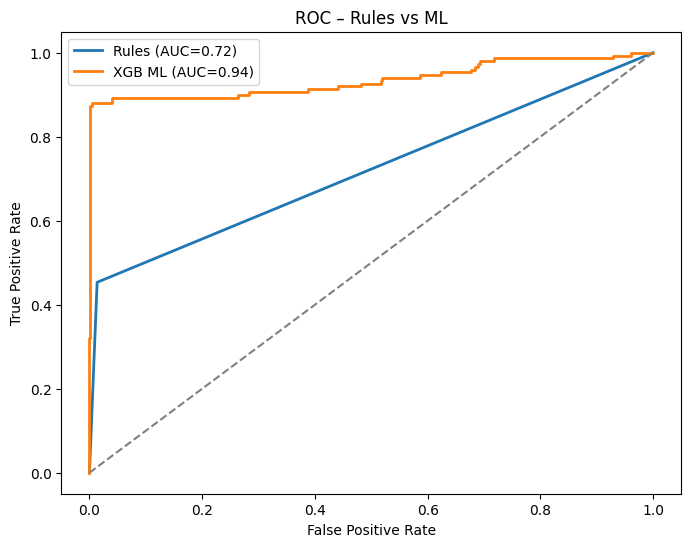

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC
fpr_rule, tpr_rule, _ = roc_curve(y, rule_flag)
fpr_ml, tpr_ml, _ = roc_curve(y, ml_score)

auc_rule = auc(fpr_rule, tpr_rule)
auc_ml = auc(fpr_ml, tpr_ml)

plt.figure(figsize=(8,6))
plt.plot(fpr_rule, tpr_rule, label=f"Rules (AUC={auc_rule:.2f})", linewidth=2)
plt.plot(fpr_ml, tpr_ml, label=f"XGB ML (AUC={auc_ml:.2f})", linewidth=2)
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Rules vs ML")
plt.legend()
plt.savefig("figures/rule_vs_ml_roc.png", dpi=300, bbox_inches="tight")
plt.show()

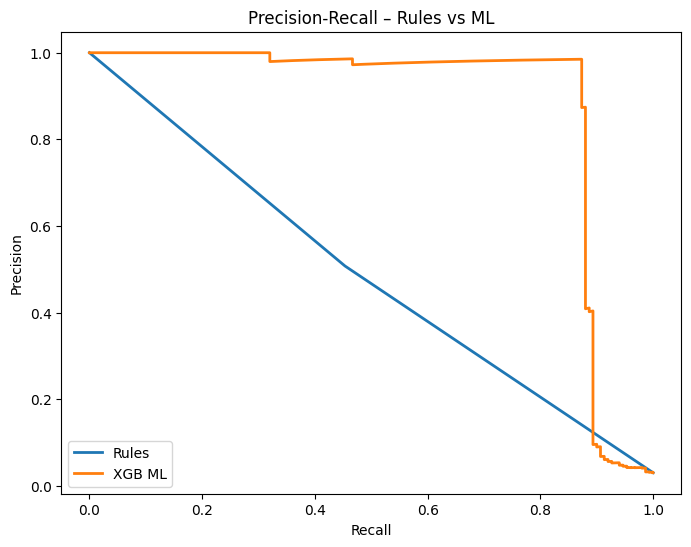

In [7]:
precision_rule, recall_rule, _ = precision_recall_curve(y, rule_flag)
precision_ml, recall_ml, _ = precision_recall_curve(y, ml_score)

plt.figure(figsize=(8,6))
plt.plot(recall_rule, precision_rule, label="Rules", linewidth=2)
plt.plot(recall_ml, precision_ml, label="XGB ML", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall – Rules vs ML")
plt.legend()
plt.savefig("figures/rule_vs_ml_prc.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
import pandas as pd

cost_df = pd.read_csv("data/best_threshold_summary.csv")

best_threshold = cost_df["threshold"][0]
best_cost      = cost_df["expected_cost"][0]

print("Best ML threshold:", best_threshold)
print("Expected ML operational cost:", best_cost)

Best ML threshold: 0.5000000000000001
Expected ML operational cost: 912600.0


In [13]:
import pandas as pd

# ---------------------------------------
# Inputs (from previous calculations)
# ---------------------------------------

# Rule metrics
tp_r = rule_metrics["tp, fp, fn, tn"][0]
fp_r = rule_metrics["tp, fp, fn, tn"][1]
fn_r = rule_metrics["tp, fp, fn, tn"][2]
tn_r = rule_metrics["tp, fp, fn, tn"][3]

# ML metrics
tp_m = ml_metrics["tp, fp, fn, tn"][0]
fp_m = ml_metrics["tp, fp, fn, tn"][1]
fn_m = ml_metrics["tp, fp, fn, tn"][2]
tn_m = ml_metrics["tp, fp, fn, tn"][3]

# ---------------------------------------
# Cost model assumptions (editable)
# ---------------------------------------
cost_false_positive = 500   # cost of manually reviewing a false alert
cost_false_negative = 3000  # cost of missing an actual mule


# ---------------------------------------
# Calculate costs
# ---------------------------------------
cost_rules = fp_r * cost_false_positive + fn_r * cost_false_negative
cost_ml    = fp_m * cost_false_positive + fn_m * cost_false_negative

cost_df = pd.DataFrame({
    "model": ["Rules", "XGB ML"],
    "false_positives": [fp_r, fp_m],
    "false_negatives": [fn_r, fn_m],
    "total_cost": [cost_rules, cost_ml]
})

cost_df

,model,false_positives,false_negatives,total_cost
0,Rules,66,82,279000
1,XGB ML,3,19,58500


In [14]:
cost_df.to_csv("data/business_case_cost_comparison.csv", index=False)
print("✓ Saved: data/business_case_cost_comparison.csv")

✓ Saved: data/business_case_cost_comparison.csv


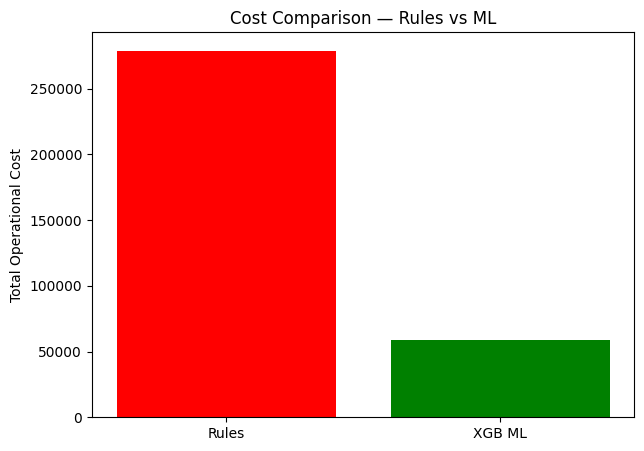

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(cost_df["model"], cost_df["total_cost"], color=["red","green"])
plt.ylabel("Total Operational Cost")
plt.title("Cost Comparison — Rules vs ML")
plt.savefig("figures/business_case_cost_comparison.png", dpi=300, bbox_inches="tight")
plt.show()